# S500 Project Stations Analysis: Weather and Economic Growth

Data wrangling of NOAA data and World Bank data using BigQuery associated with the s500-project on ac-99's github. 

Author: Anubhav Chowdhury, University of Cambridge (MPhil in Economic Research), https://github.com/ac-99

Date: May 2022

Project abstract: This essay exploits year-to-year temperature and precipitation variation to estimate the effects of weather on economic growth using fixed effects methods, a la Dell (2012). This essay hypothesises, based on a large volume of micro-level evidence, that agricultural effects mediate the relationship between weather and economic growth. This problem is analysed using fixed effects regression methods, using dynamic measures for poverty and agriculture, rather than the static measures used by Dell (2021). This analysis is based on a US National Oceanic and Atmospheric Administration (NOAA) dataset with over 90 million observations from over 15,000 weather stations and World Bank Development Indicators between 1992 and 2017.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python 
# For example, here's several helpful packages to load

# Data wrangling and analysis
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import bq_helper 
# from bq_helper import BigQueryHelper

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
sns.set_palette("magma")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import shutil
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        
os.system('pip install linearmodels')
import linearmodels # pip install
from linearmodels import PanelOLS
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/weather-gdp/weather_GDP.csv


#### Reading in data
Only data to read in is weather_GDP from S500: data.

In [2]:
weather_GDP = pd.read_csv('../input/weather-gdp/weather_GDP.csv') 

## Data Analysis

Use fixed effects regression with both time and entity effects to model structurally different growth rates amongst countries. This allows the relationship between GDP growth and temperature effects to be more directly modelled.

Several regressions are modelled: to consider the bellow effects. Regressions (1) to (5) allow validation of Dell et al (2012). (6) tests the primary hypothesis of the essay: that the effects of weather on growth are mediated through the impact of temperature changes on agriculture. 

*The case for agriculture as a mediating factor is strong. For example, Guiteras (2009) demonstrates that above average annual temperatures reduce agricultural production in India. When extrapolated to the long run without farmer adaptation,  Guiteras (2009) estimates a 25\% fall in agricultural output by 2070 – 2099. This will substantially reduce economic output in a country where 52% of employment is in agriculture (ibid). If agriculture is a mediating factor, this exposes a need for policies promoting mitigation against weather and climate shocks, such as the adaptation of farming practices. Resulting improvements in short run and long run growth provide strong motivation for this area of research.*

See essay for extended discussion of motivation and evidence.   

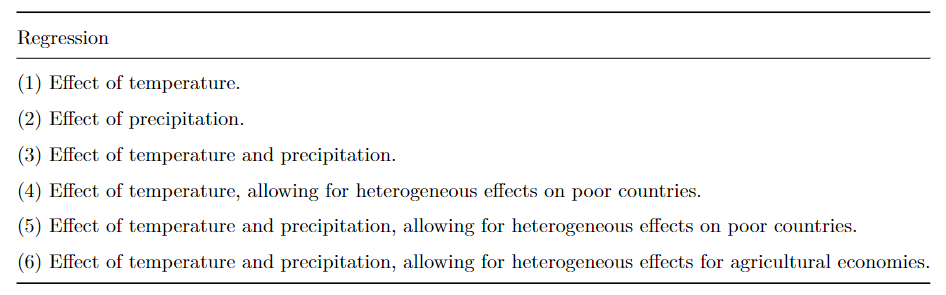

The complete discussion of the evidence is provided in the associated essay in the repo. To summarise:
* No evidence of any effect of precipitation on growth rates, possibly due to non-linearities in precipitation.
* The effect of temperature is (unexpectedly) positive. This may be a product of choice of entity effects.
* There is no evidence of agricultural effects as a mediating factor.

In [3]:
# Take differences
weather_GDP= weather_GDP.reset_index()
weather_diff = weather_GDP.copy()
weather_diff['avg_temp'] = weather_GDP.groupby('country')['avg_temp'].diff()
weather_diff['avg_precip'] = weather_GDP.groupby('country')['avg_precip'].diff()
weather_diff['avg_precipXpoor'] = weather_diff['avg_precip']*weather_diff['poor']
weather_diff['avg_tempXpoor'] = weather_diff['avg_temp']*weather_diff['poor']
weather_diff['avg_tempXagricultural'] = weather_diff['avg_temp']*weather_diff['agricultural']
weather_diff['avg_precipXagricultural'] = weather_diff['avg_precip']*weather_diff['agricultural']

# MultiIndex, entity - time
weather_diff = weather_diff.set_index(['country','year'])

weather_diff.tail()

,,index,Unnamed: 0,avg_temp,avg_precip,agricultural,growth,gdp,population,year_median_gdp,year_median_temp,poor,hot,large,avg_precipXpoor,avg_tempXpoor,avg_tempXagricultural,avg_precipXagricultural
country,year,,,,,,,,,,,,,,,,,
Uzbekistan,2000,4714,4714,-0.039835,-5.133118,30.055904,3.800000,6.171616e+10,24650400.0,4.079908e+10,22.864531,False,False,True,-0.000000,-0.000000,-1.197265,-154.280490
Vanuatu,2000,4715,4715,-0.365225,-1.871099,22.964130,5.922045,5.224175e+08,185063.0,4.079908e+10,22.864531,True,True,False,-1.871099,-0.365225,-8.387083,-42.968168
Vietnam,2000,4716,4716,0.938526,-2.500459,24.534582,6.787316,2.057000e+11,80285562.0,4.079908e+10,22.864531,False,True,True,-0.000000,0.000000,23.026355,-61.347726
Zambia,2000,4717,4717,-0.409981,-7.705034,16.149773,3.897323,2.214698e+10,10531221.0,4.079908e+10,22.864531,True,False,True,-7.705034,-0.409981,-6.621104,-124.434551
Zimbabwe,2000,4718,4718,-0.431084,-0.062505,15.667063,-3.059190,3.500275e+10,12222251.0,4.079908e+10,22.864531,True,False,True,-0.062505,-0.431084,-6.753819,-0.979273


#### Regression 1

Effect of precipitation.

In [4]:
mod = PanelOLS(weather_diff.growth, weather_diff[['avg_temp']], entity_effects=True, time_effects=True)
print(mod.fit())

/opt/conda/lib/python3.7/site-packages/linearmodels/shared/exceptions.py:37: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:                 growth   R-squared:                        0.0071
Estimator:                   PanelOLS   R-squared (Between):              0.0055
No. Observations:                4181   R-squared (Within):               0.0046
Date:                Sun, May 22 2022   R-squared (Overall):              0.0040
Time:                        21:43:48   Log-likelihood                -1.305e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      28.227
Entities:                         181   P-value                           0.0000
Avg Obs:                       23.099   Distribution:                  F(1,3975)
Min Obs:                       2.0000                                           
Max Obs:                       25.000   F-statistic (robust):             28.227
                            

#### Regression 2
Effect of precipitation.

In [5]:
mod = PanelOLS(weather_diff.growth, weather_diff[['avg_precip']], entity_effects=True, time_effects=True)
print(mod.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:                 growth   R-squared:                       3.7e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0005
No. Observations:                4181   R-squared (Within):            3.567e-05
Date:                Sun, May 22 2022   R-squared (Overall):             -0.0001
Time:                        21:43:49   Log-likelihood                -1.307e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.1471
Entities:                         181   P-value                           0.7014
Avg Obs:                       23.099   Distribution:                  F(1,3975)
Min Obs:                       2.0000                                           
Max Obs:                       25.000   F-statistic (robust):             0.1471
                            

#### Regression 3
Effect of temperature and precipitation. 

In [6]:
mod = PanelOLS(weather_diff.growth, weather_diff[['avg_temp','avg_precip']], entity_effects=True, time_effects=True)
print(mod.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:                 growth   R-squared:                        0.0071
Estimator:                   PanelOLS   R-squared (Between):              0.0057
No. Observations:                4181   R-squared (Within):               0.0046
Date:                Sun, May 22 2022   R-squared (Overall):              0.0041
Time:                        21:43:49   Log-likelihood                -1.305e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      14.119
Entities:                         181   P-value                           0.0000
Avg Obs:                       23.099   Distribution:                  F(2,3974)
Min Obs:                       2.0000                                           
Max Obs:                       25.000   F-statistic (robust):             14.119
                            

#### Regression 4

Effect of temperature, allowing for heterogeneous effects on poor countries.

In [7]:
mod = PanelOLS(weather_diff.growth, weather_diff[['avg_temp','avg_tempXpoor']], entity_effects=True, time_effects=True)
print(mod.fit())
formula = 'avg_temp + avg_tempXpoor = 0'
mod.fit().wald_test(formula=formula)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 growth   R-squared:                        0.0085
Estimator:                   PanelOLS   R-squared (Between):              0.0046
No. Observations:                4181   R-squared (Within):               0.0058
Date:                Sun, May 22 2022   R-squared (Overall):              0.0046
Time:                        21:43:50   Log-likelihood                -1.305e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      16.971
Entities:                         181   P-value                           0.0000
Avg Obs:                       23.099   Distribution:                  F(2,3974)
Min Obs:                       2.0000                                           
Max Obs:                       25.000   F-statistic (robust):             16.971
                            

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 7.9446
P-value: 0.0048
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fab4bed7210

#### Regression 5
Effect of temperature and precipitation, allowing for heterogeneous effects on poor countries. 

In [8]:
mod = PanelOLS(weather_diff.growth, weather_diff[['avg_temp', 
                                                  'avg_precip',
                                                  'avg_precipXpoor',
                                                  'avg_tempXpoor']], entity_effects=True, time_effects=True)
print(mod.fit())
formula = 'avg_temp + avg_tempXpoor = 0'
mod.fit().wald_test(formula=formula)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 growth   R-squared:                        0.0086
Estimator:                   PanelOLS   R-squared (Between):              0.0048
No. Observations:                4181   R-squared (Within):               0.0059
Date:                Sun, May 22 2022   R-squared (Overall):              0.0047
Time:                        21:43:50   Log-likelihood                -1.305e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.6018
Entities:                         181   P-value                           0.0000
Avg Obs:                       23.099   Distribution:                  F(4,3972)
Min Obs:                       2.0000                                           
Max Obs:                       25.000   F-statistic (robust):             8.6018
                            

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 8.1029
P-value: 0.0044
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fab41ddf810

In [9]:
formula = 'avg_precip + avg_precipXpoor = 0'
mod.fit().wald_test(formula=formula)

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 0.2632
P-value: 0.6079
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fab41ddf990

#### Regression 6
Effect of temperature and precipitation, allowing for heterogeneous effects for agricultural economies.

In [10]:
mod = PanelOLS(weather_diff.growth, weather_diff[['avg_temp', 
                                                  'avg_precip',
                                                  'avg_precipXagricultural',
                                                  'avg_tempXagricultural']], entity_effects=True, time_effects=True)
# fe_reg=mod.fit()
# print(fe_reg) -- FOR TESTING
print(mod.fit())

formula = 'avg_temp + avg_tempXagricultural = 0'
print("AVG TEMP")
mod.fit().wald_test(formula=formula)


                          PanelOLS Estimation Summary                           
Dep. Variable:                 growth   R-squared:                        0.0015
Estimator:                   PanelOLS   R-squared (Between):              0.0067
No. Observations:                3903   R-squared (Within):               0.0005
Date:                Sun, May 22 2022   R-squared (Overall):              0.0007
Time:                        21:43:52   Log-likelihood                -1.131e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.3587
Entities:                         176   P-value                           0.2457
Avg Obs:                       22.176   Distribution:                  F(4,3699)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             1.3587
                            

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 0.2145
P-value: 0.6432
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fab41d80910

In [11]:
formula = 'avg_precip + avg_precipXagricultural = 0'
print("AVG PRECIP")
mod.fit().wald_test(formula=formula)

AVG PRECIP


Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 2.4020
P-value: 0.1212
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fab41ddfc10

In [12]:
# from linearmodels.panel import generate_panel_data
# panel_data = generate_panel_data()
# mod = PanelOLS.from_formula('y ~ 1 + x1 + EntityEffects', panel_data.data)

## Plotting

The below include:
1. A GDP histogram
2. A GDP-Temperature GDP pairplot
3. A GDP-Agricultural sector size pairplot
4. A Temperature-Agriculture pairplot.
5. A data availability plot.

Plot (1) is basic exploratory analysis, and a sanity check. Plots (2)-(3) demonstrate the possibility of omitted variable bias. (5) maps out data availability over time. A full discussion of the plots is given in the associated essay.

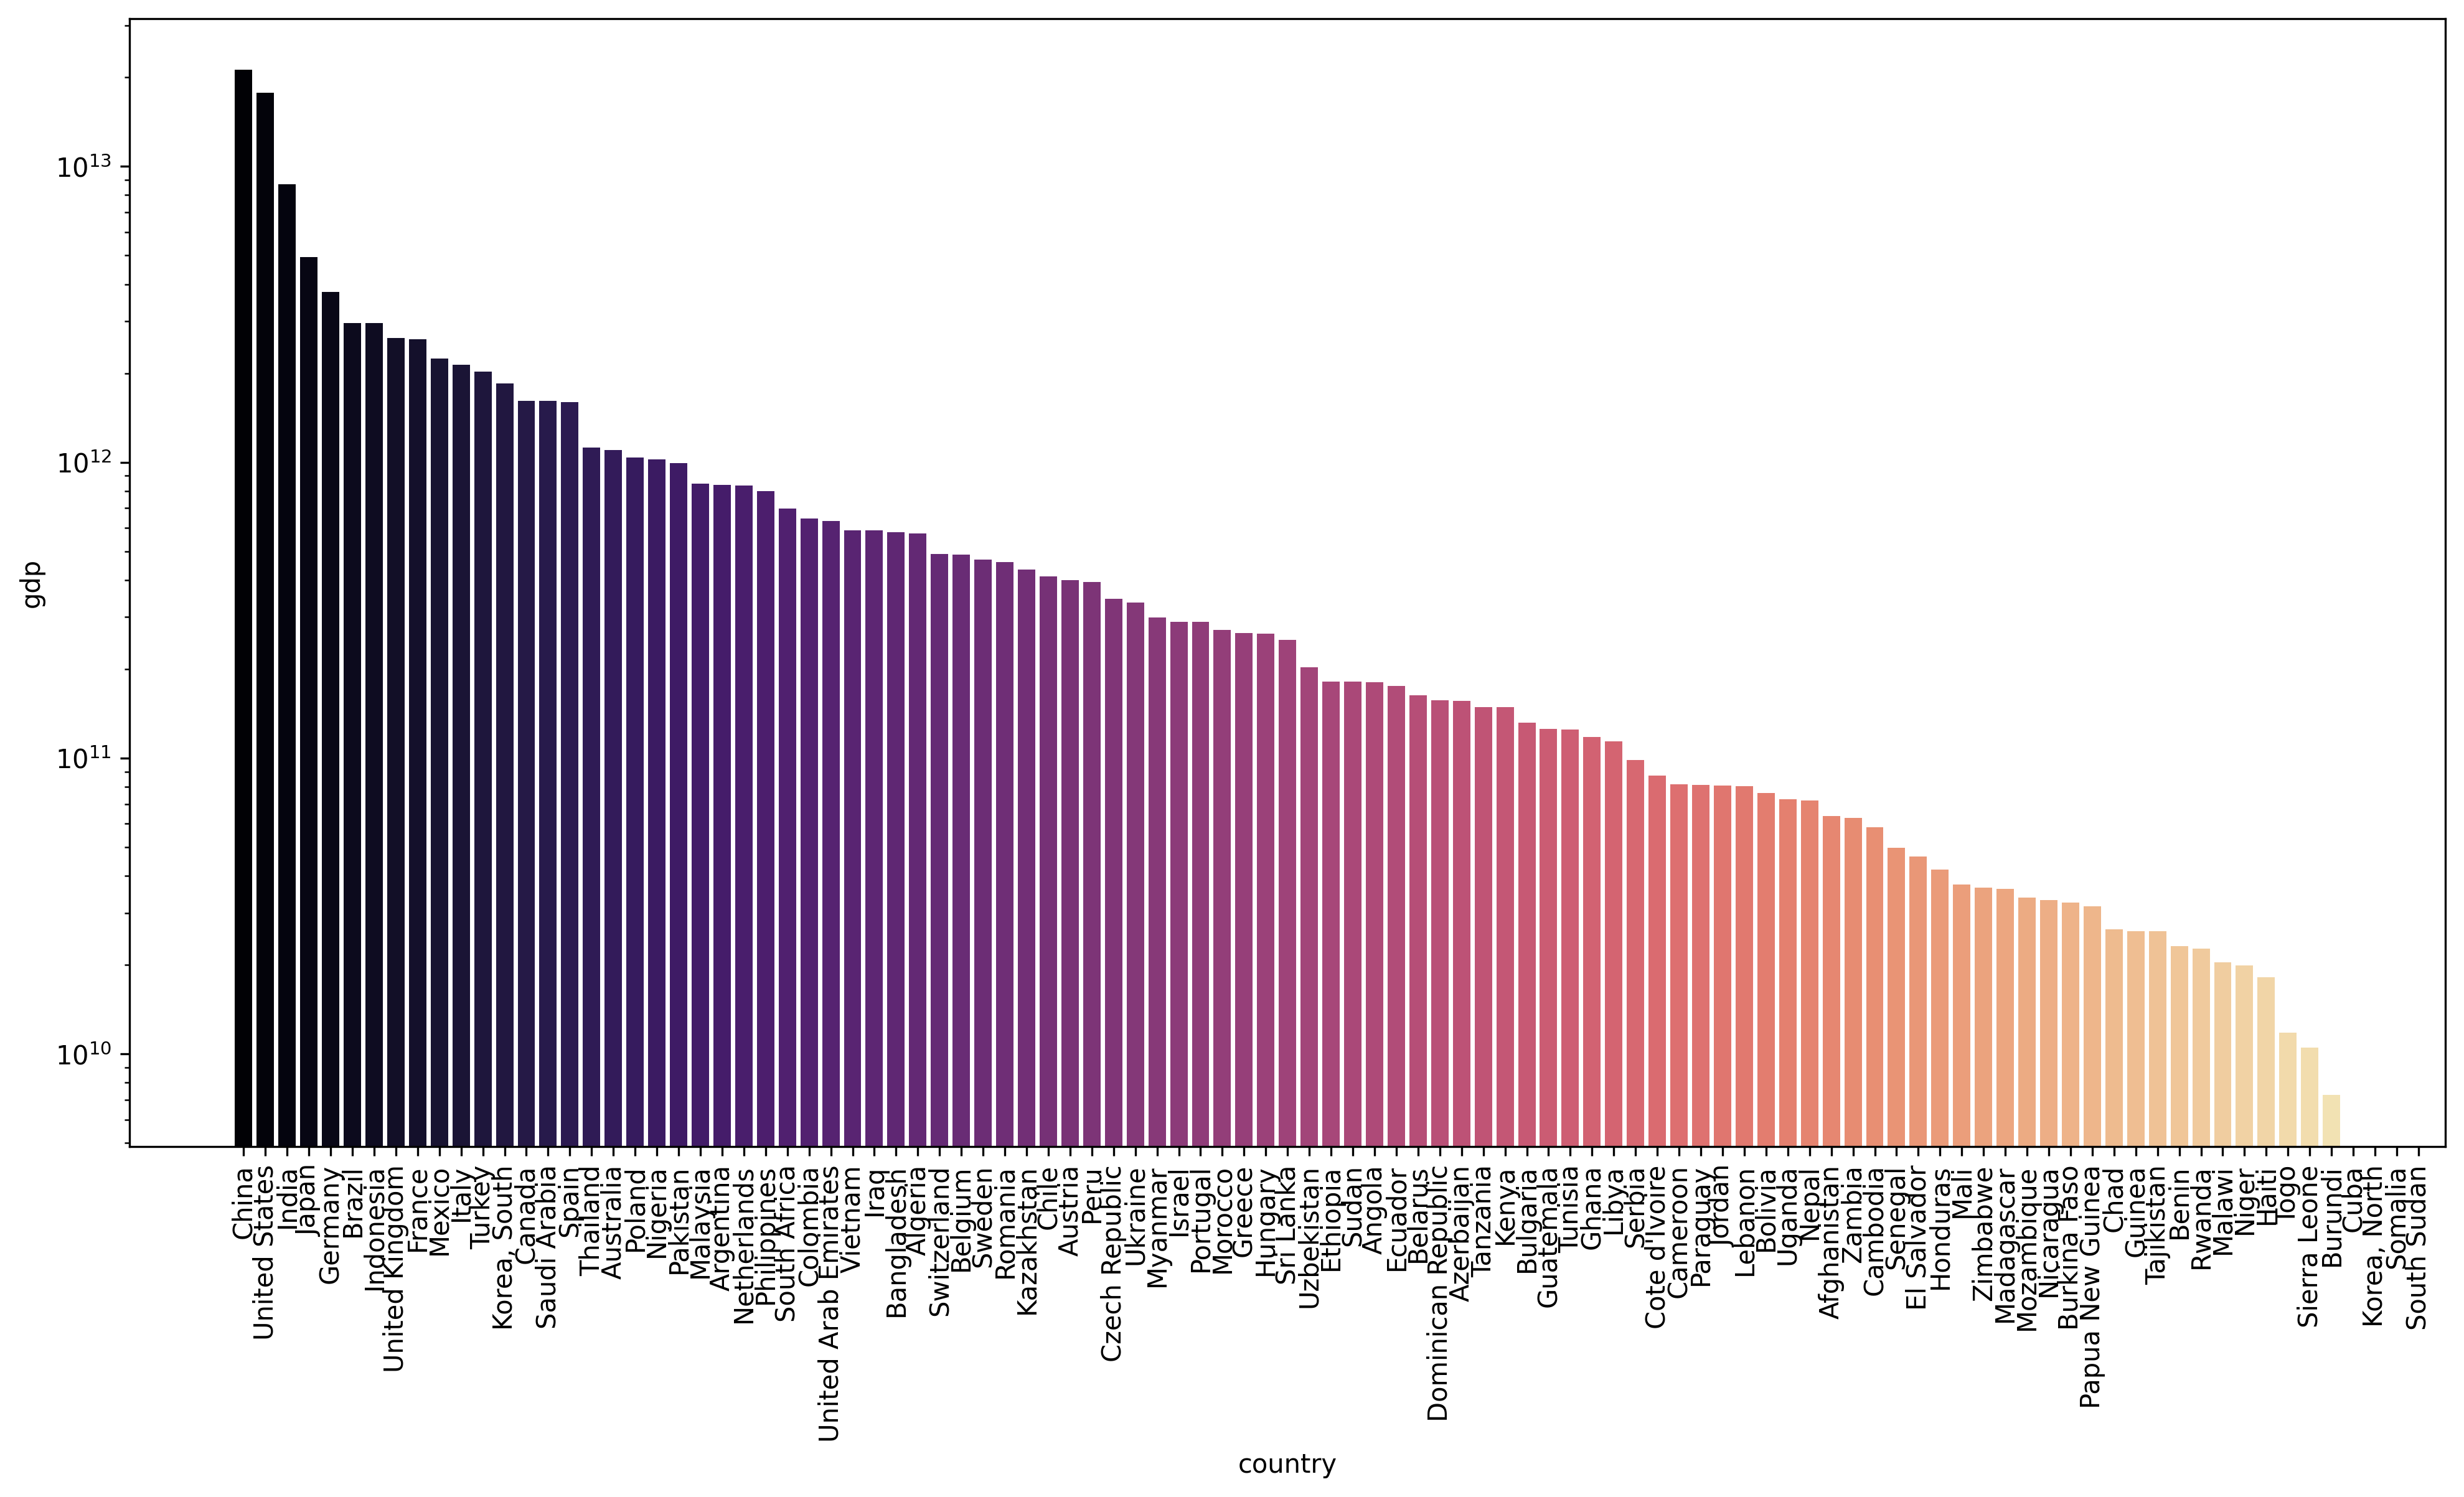

In [13]:
# # Fix: ordered based on single year (max values)
plot_data=weather_GDP[(weather_GDP['large']==1)&
                    (weather_GDP['year']==2017)].sort_values('gdp',ascending = False).copy()

plt.figure(figsize=(16, 8))

ax=sns.barplot(
    data=plot_data,
    x="country", y='gdp',palette='magma'
)


ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_yscale('log')
ax.plot()
plt.savefig("gdp_hist_2017")

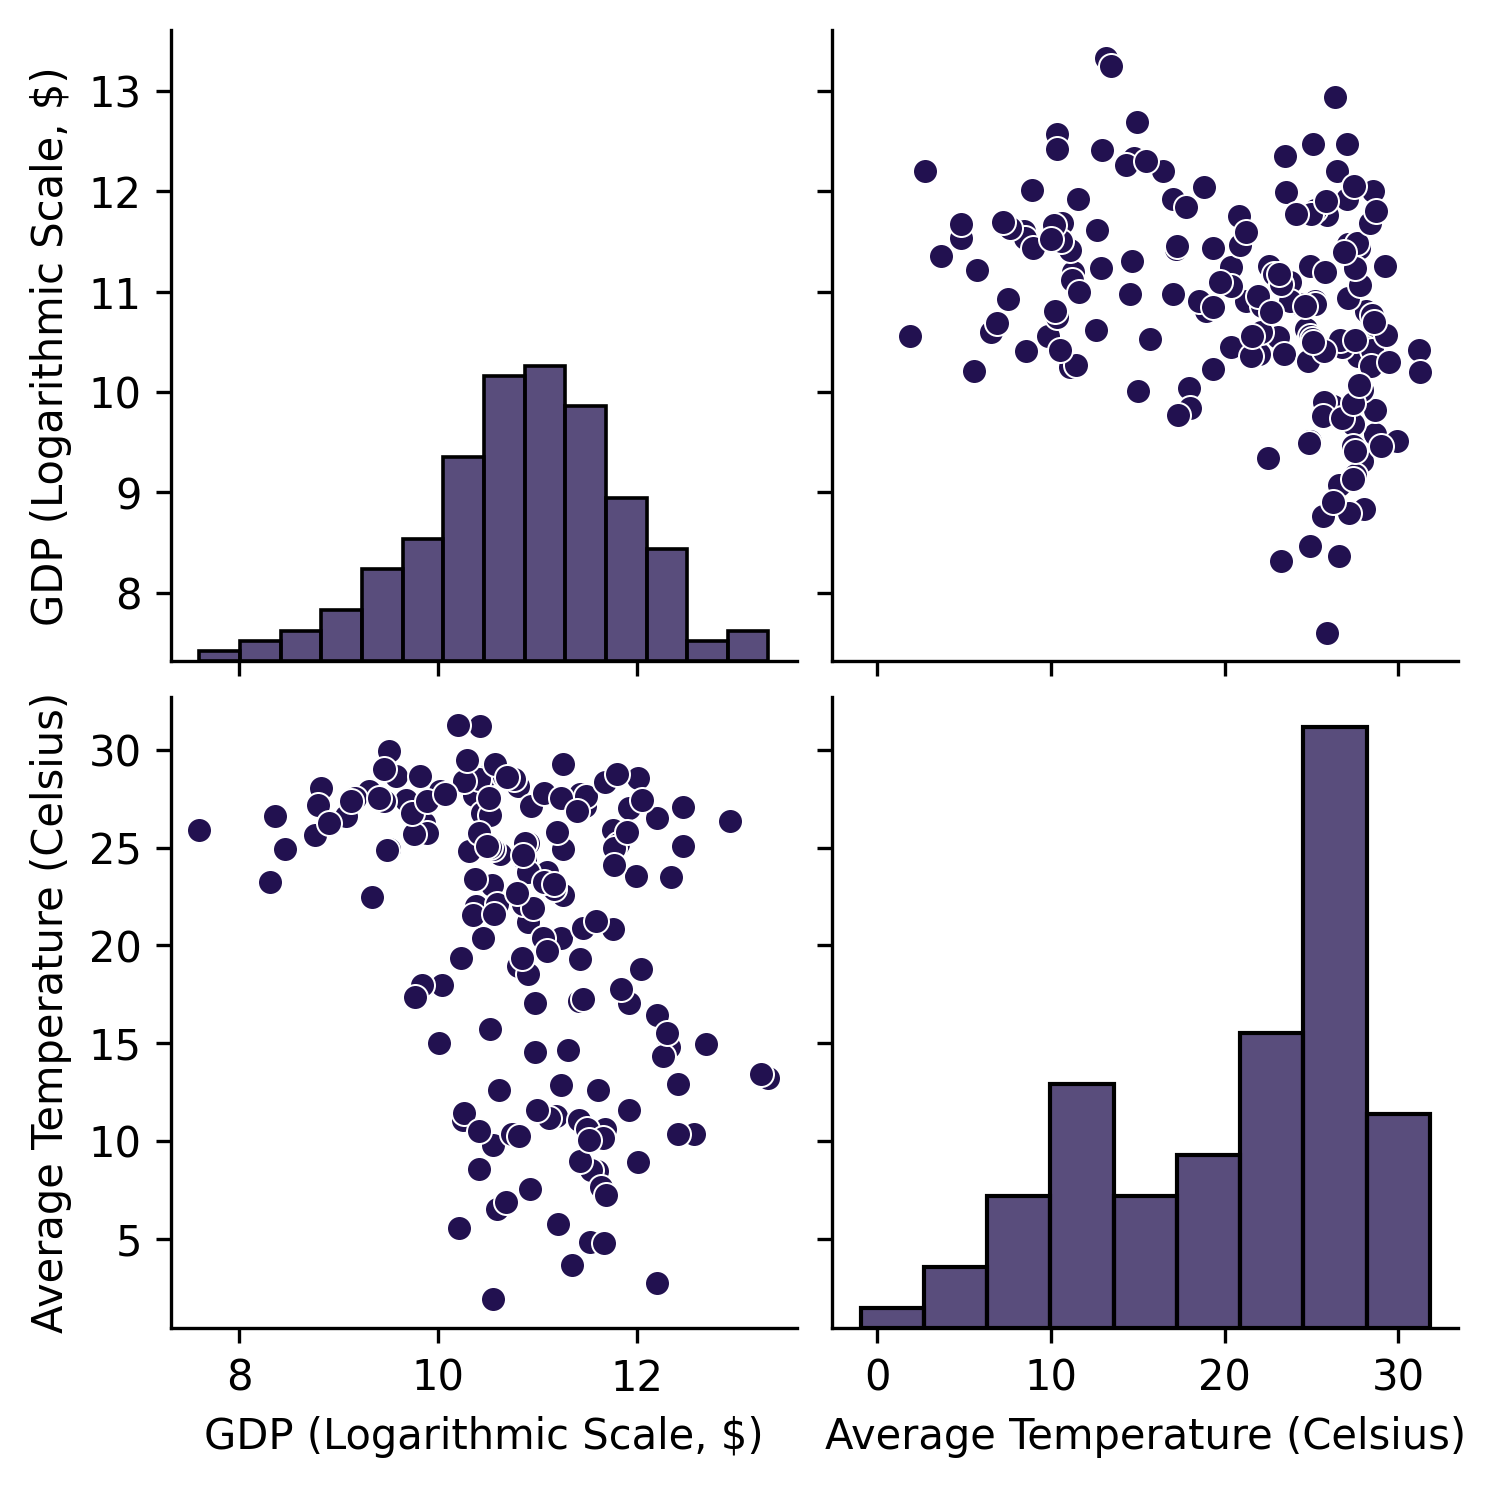

In [14]:
# Fix: ordered based on single year (max values)

# plt.figure(figsize=(6,6))
# # plt.yscale('log')
weather_GDP['GDP (Logarithmic Scale, $)'] = np.log10(weather_GDP['gdp'])
# # weather_GDP['GDP per capita ($)'] = weather_GDP['gdp']/weather_GDP['population']
weather_GDP['Average Temperature (Celcius)']=weather_GDP['avg_temp'] 
weather_GDP['Average Temperature (Celsius)']=weather_GDP['avg_temp'] 
weather_GDP['Average Temperature (Celsius)']=weather_GDP['avg_temp'] 
weather_GDP['Agricultural Sector (% of GDP)']=weather_GDP['agricultural']  

ax=sns.pairplot(
    data=weather_GDP[weather_GDP['year']==2017][['GDP (Logarithmic Scale, $)','Average Temperature (Celsius)']]
)
plt.savefig("pairplot_temp_gdp")

<Figure size 1800x1800 with 0 Axes>

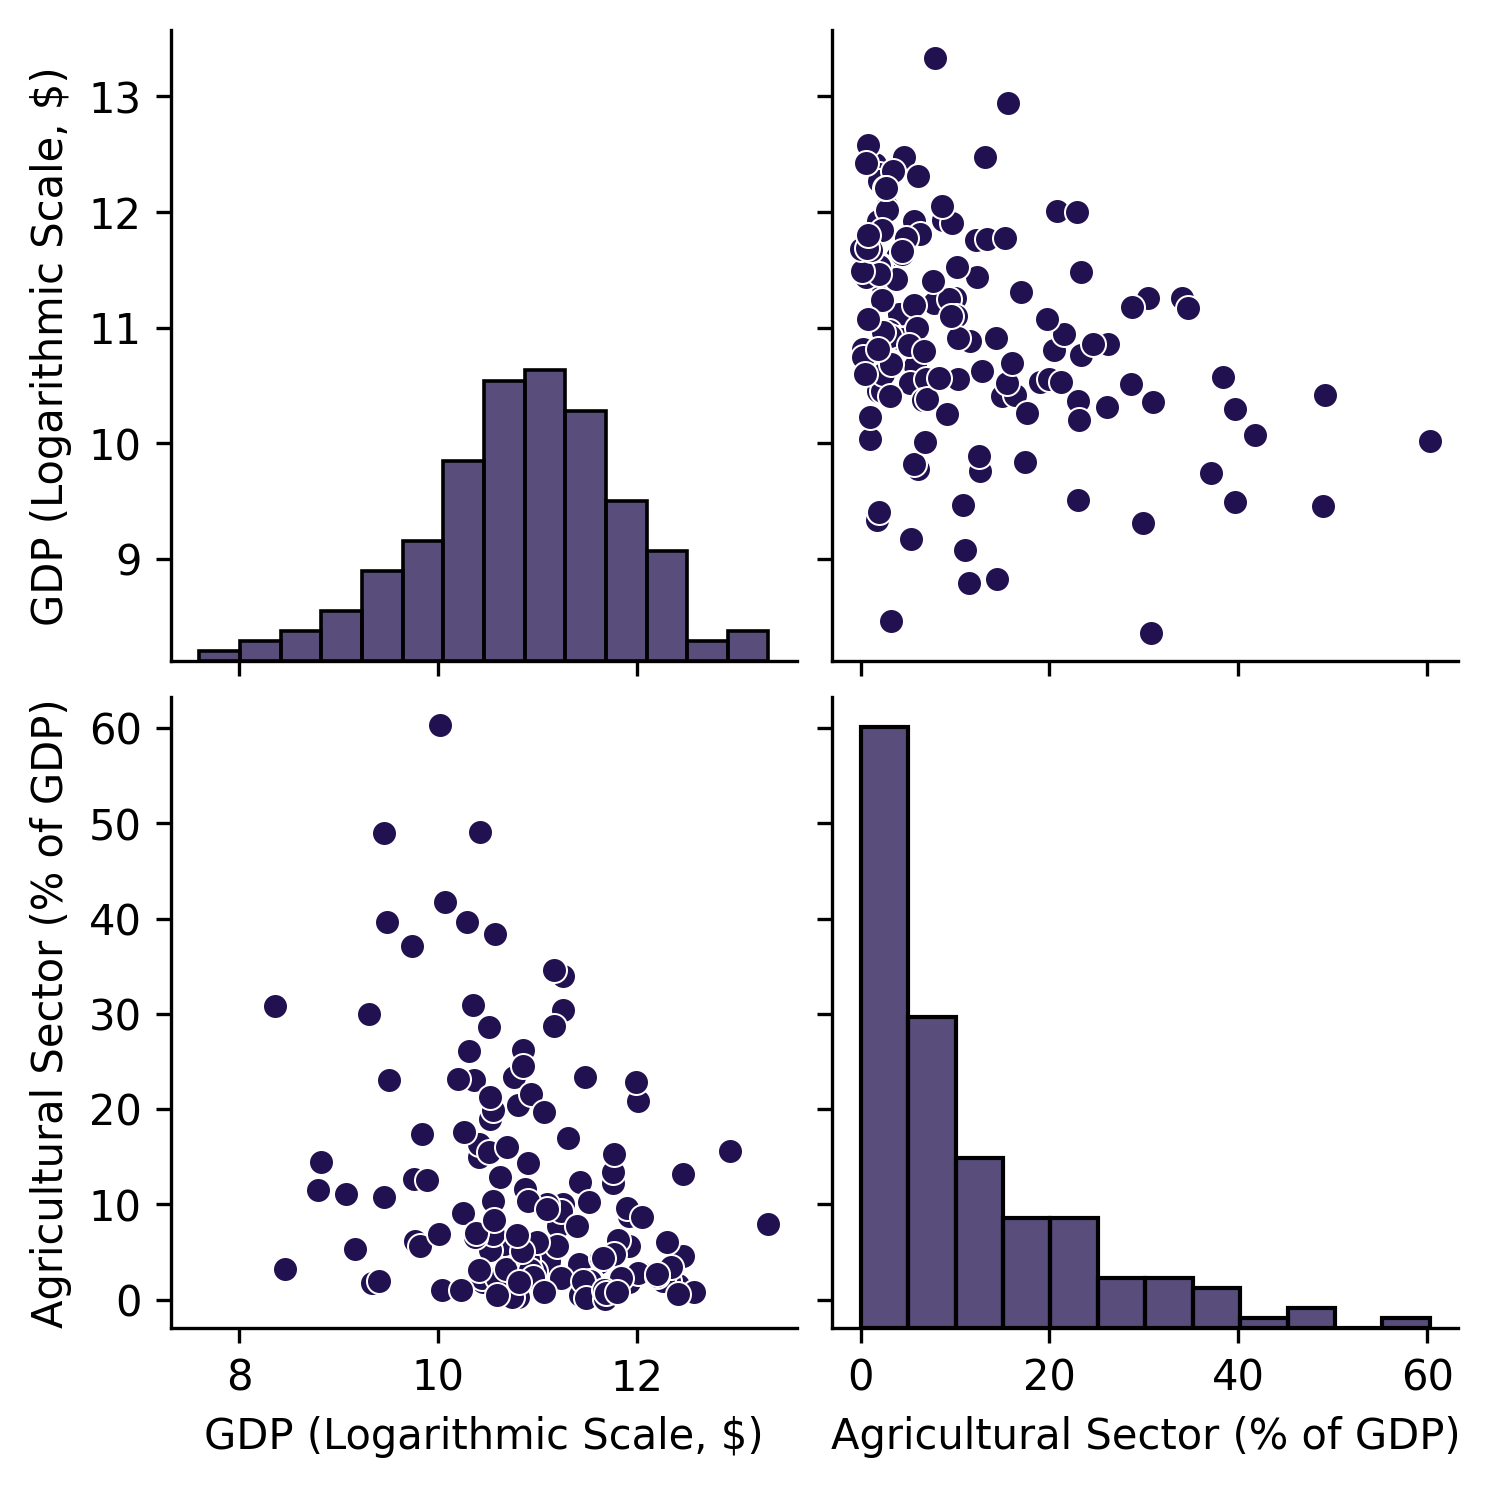

In [15]:
plt.figure(figsize=(6,6))
ax=sns.pairplot(
    data=weather_GDP[weather_GDP['year']==2017][['GDP (Logarithmic Scale, $)','Agricultural Sector (% of GDP)']]
)
plt.savefig("pairplot_agricultural_gdp")

<Figure size 1800x1800 with 0 Axes>

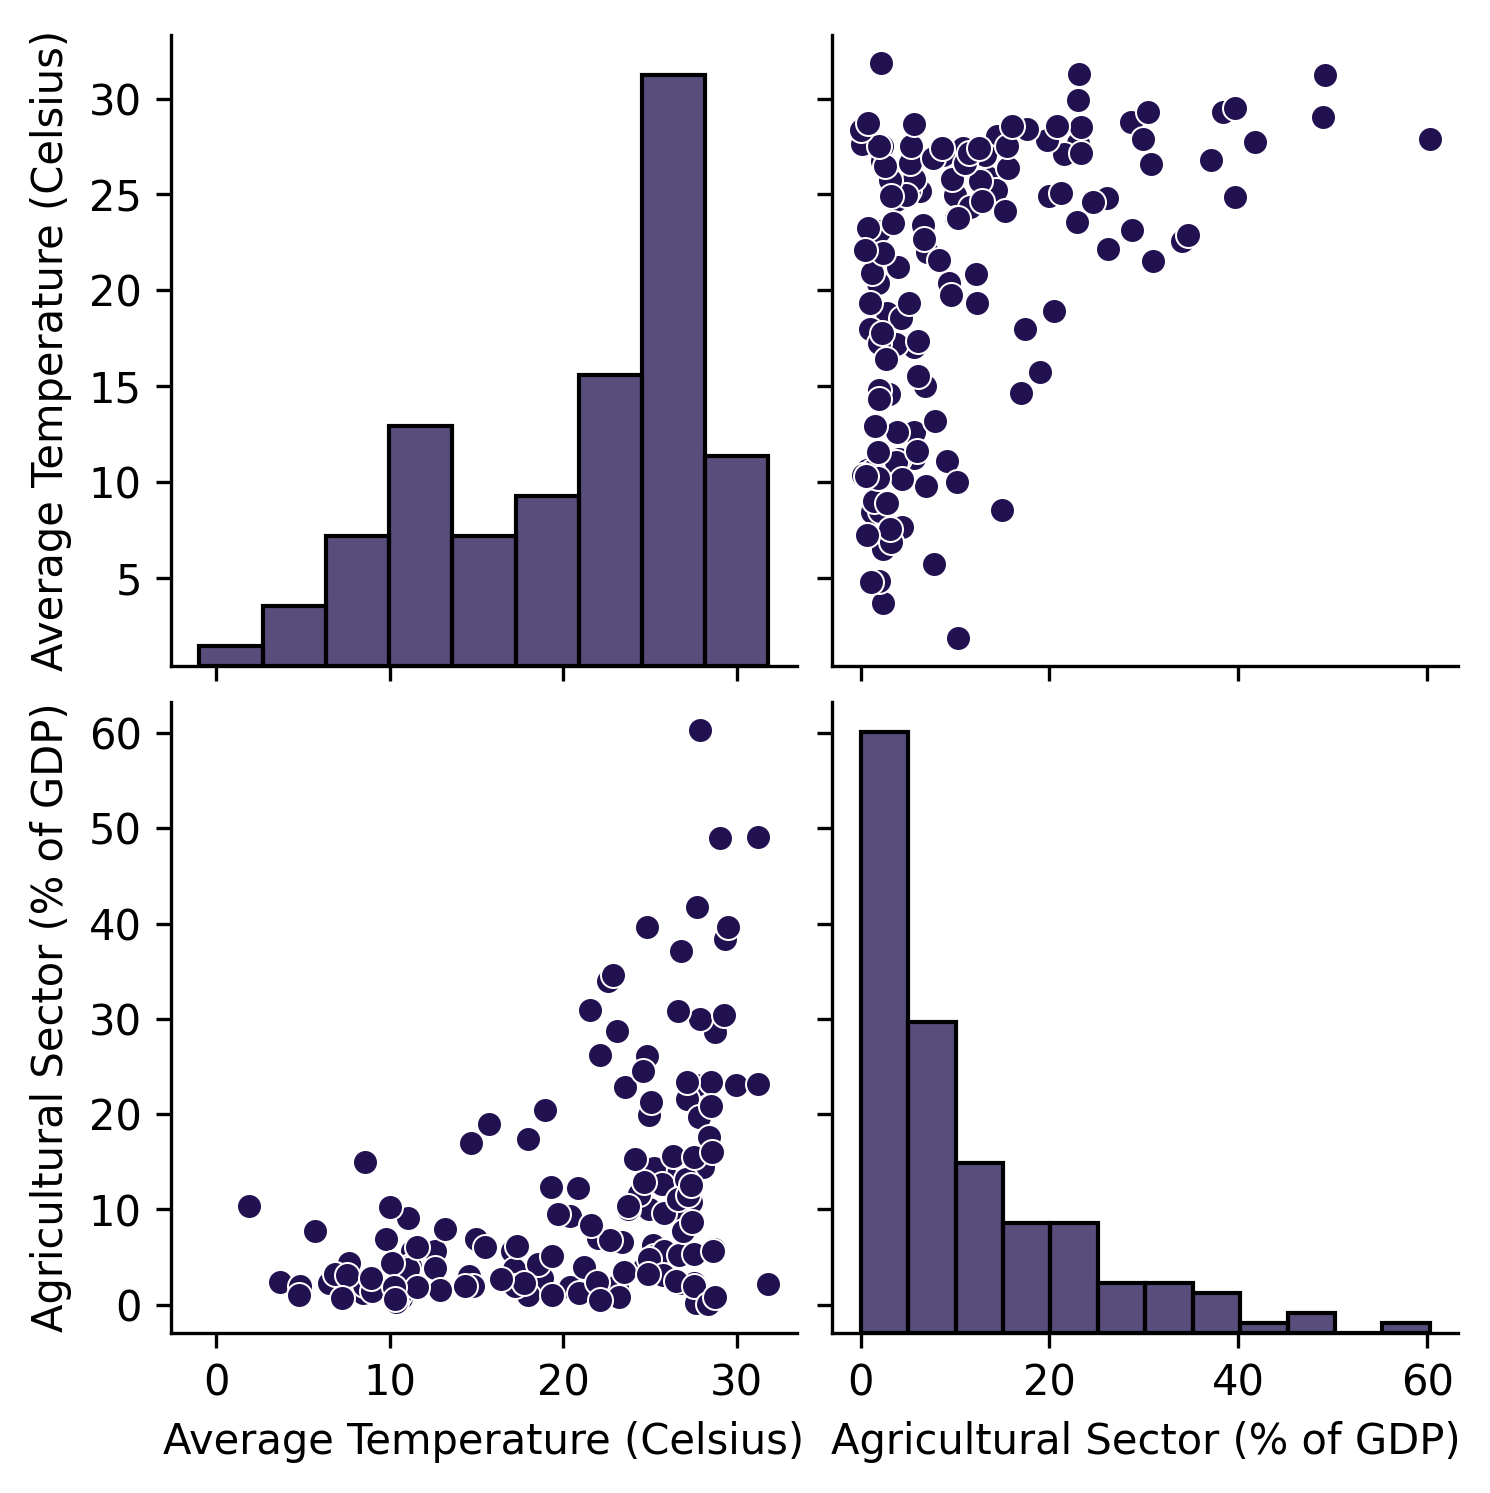

In [16]:
# # # Fix: ordered based on single year (max values)
plt.figure(figsize=(6,6))


ax=sns.pairplot(
    data=weather_GDP[weather_GDP['year']==2017][['Average Temperature (Celsius)','Agricultural Sector (% of GDP)']]
)
plt.savefig("pairplot_temp_agricultural")

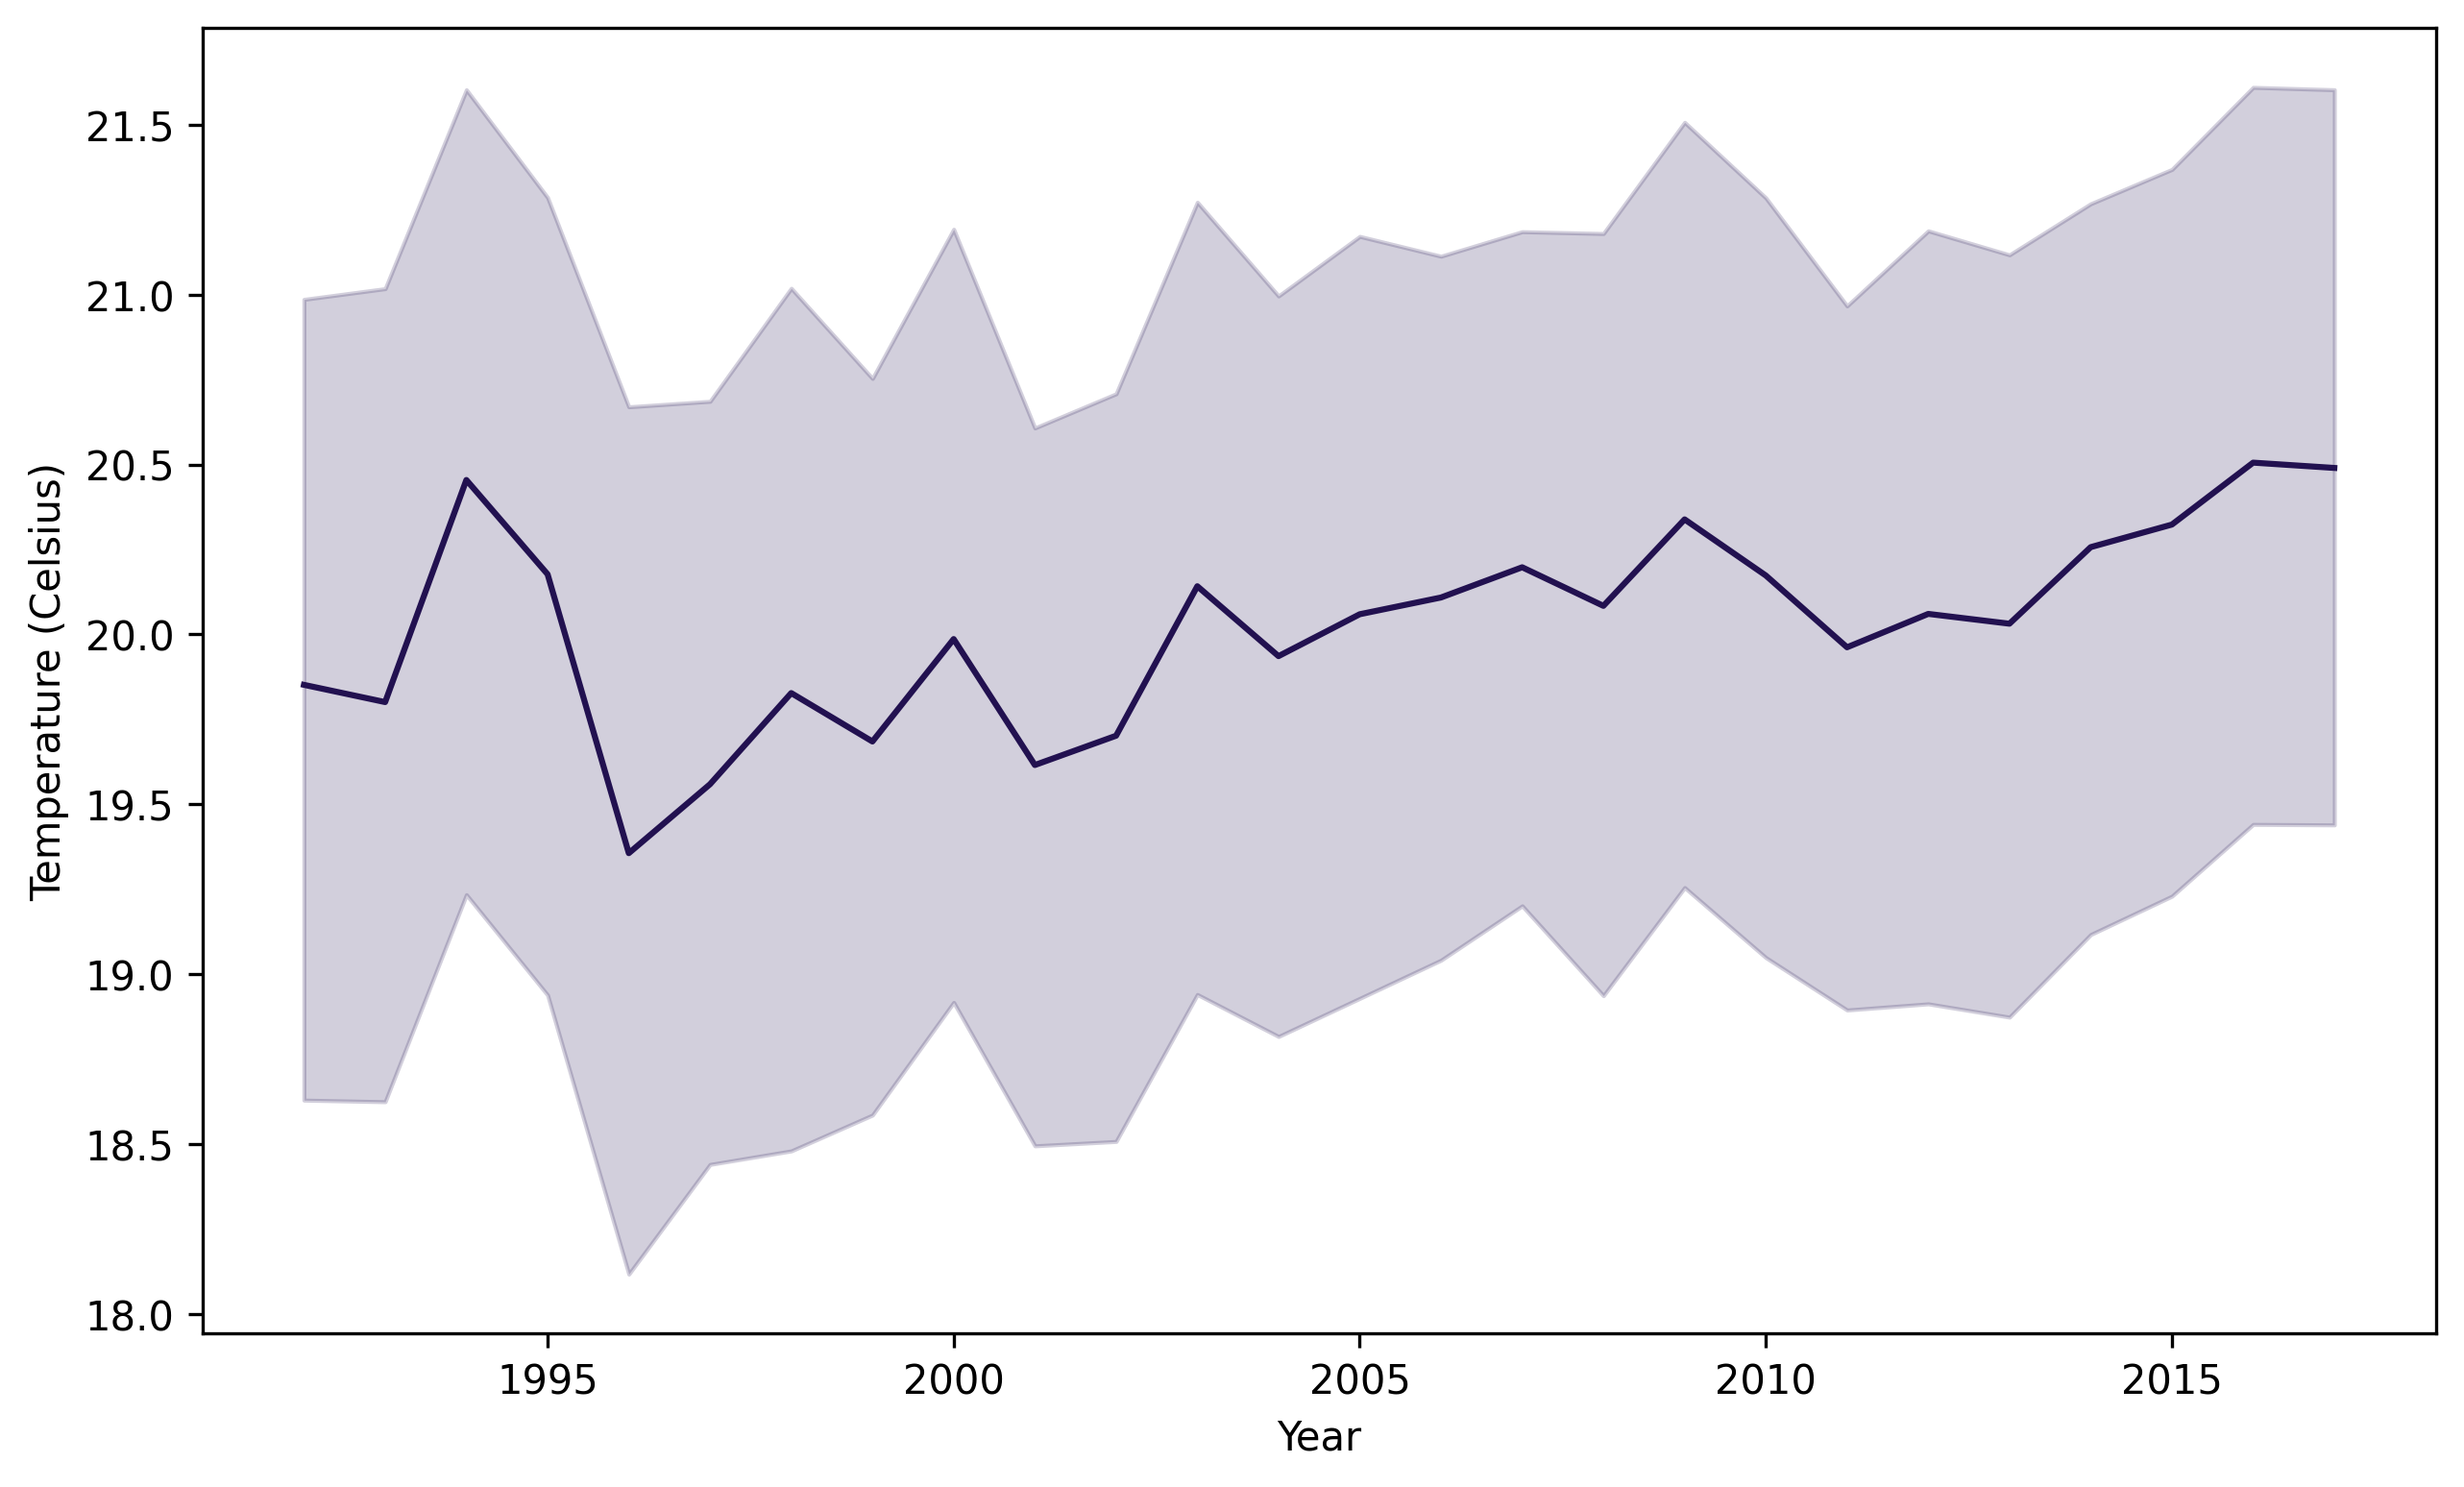

In [17]:
# Average temperature over time

plt.figure(figsize=(10,6))
sns.lineplot(x='year',y='avg_temp',
             data=weather_GDP[['country','avg_temp','year']],
             legend=False)
plt.xlabel(xlabel="Year")
plt.ylabel(ylabel="Temperature (Celsius)")
plt.savefig("temp_time")


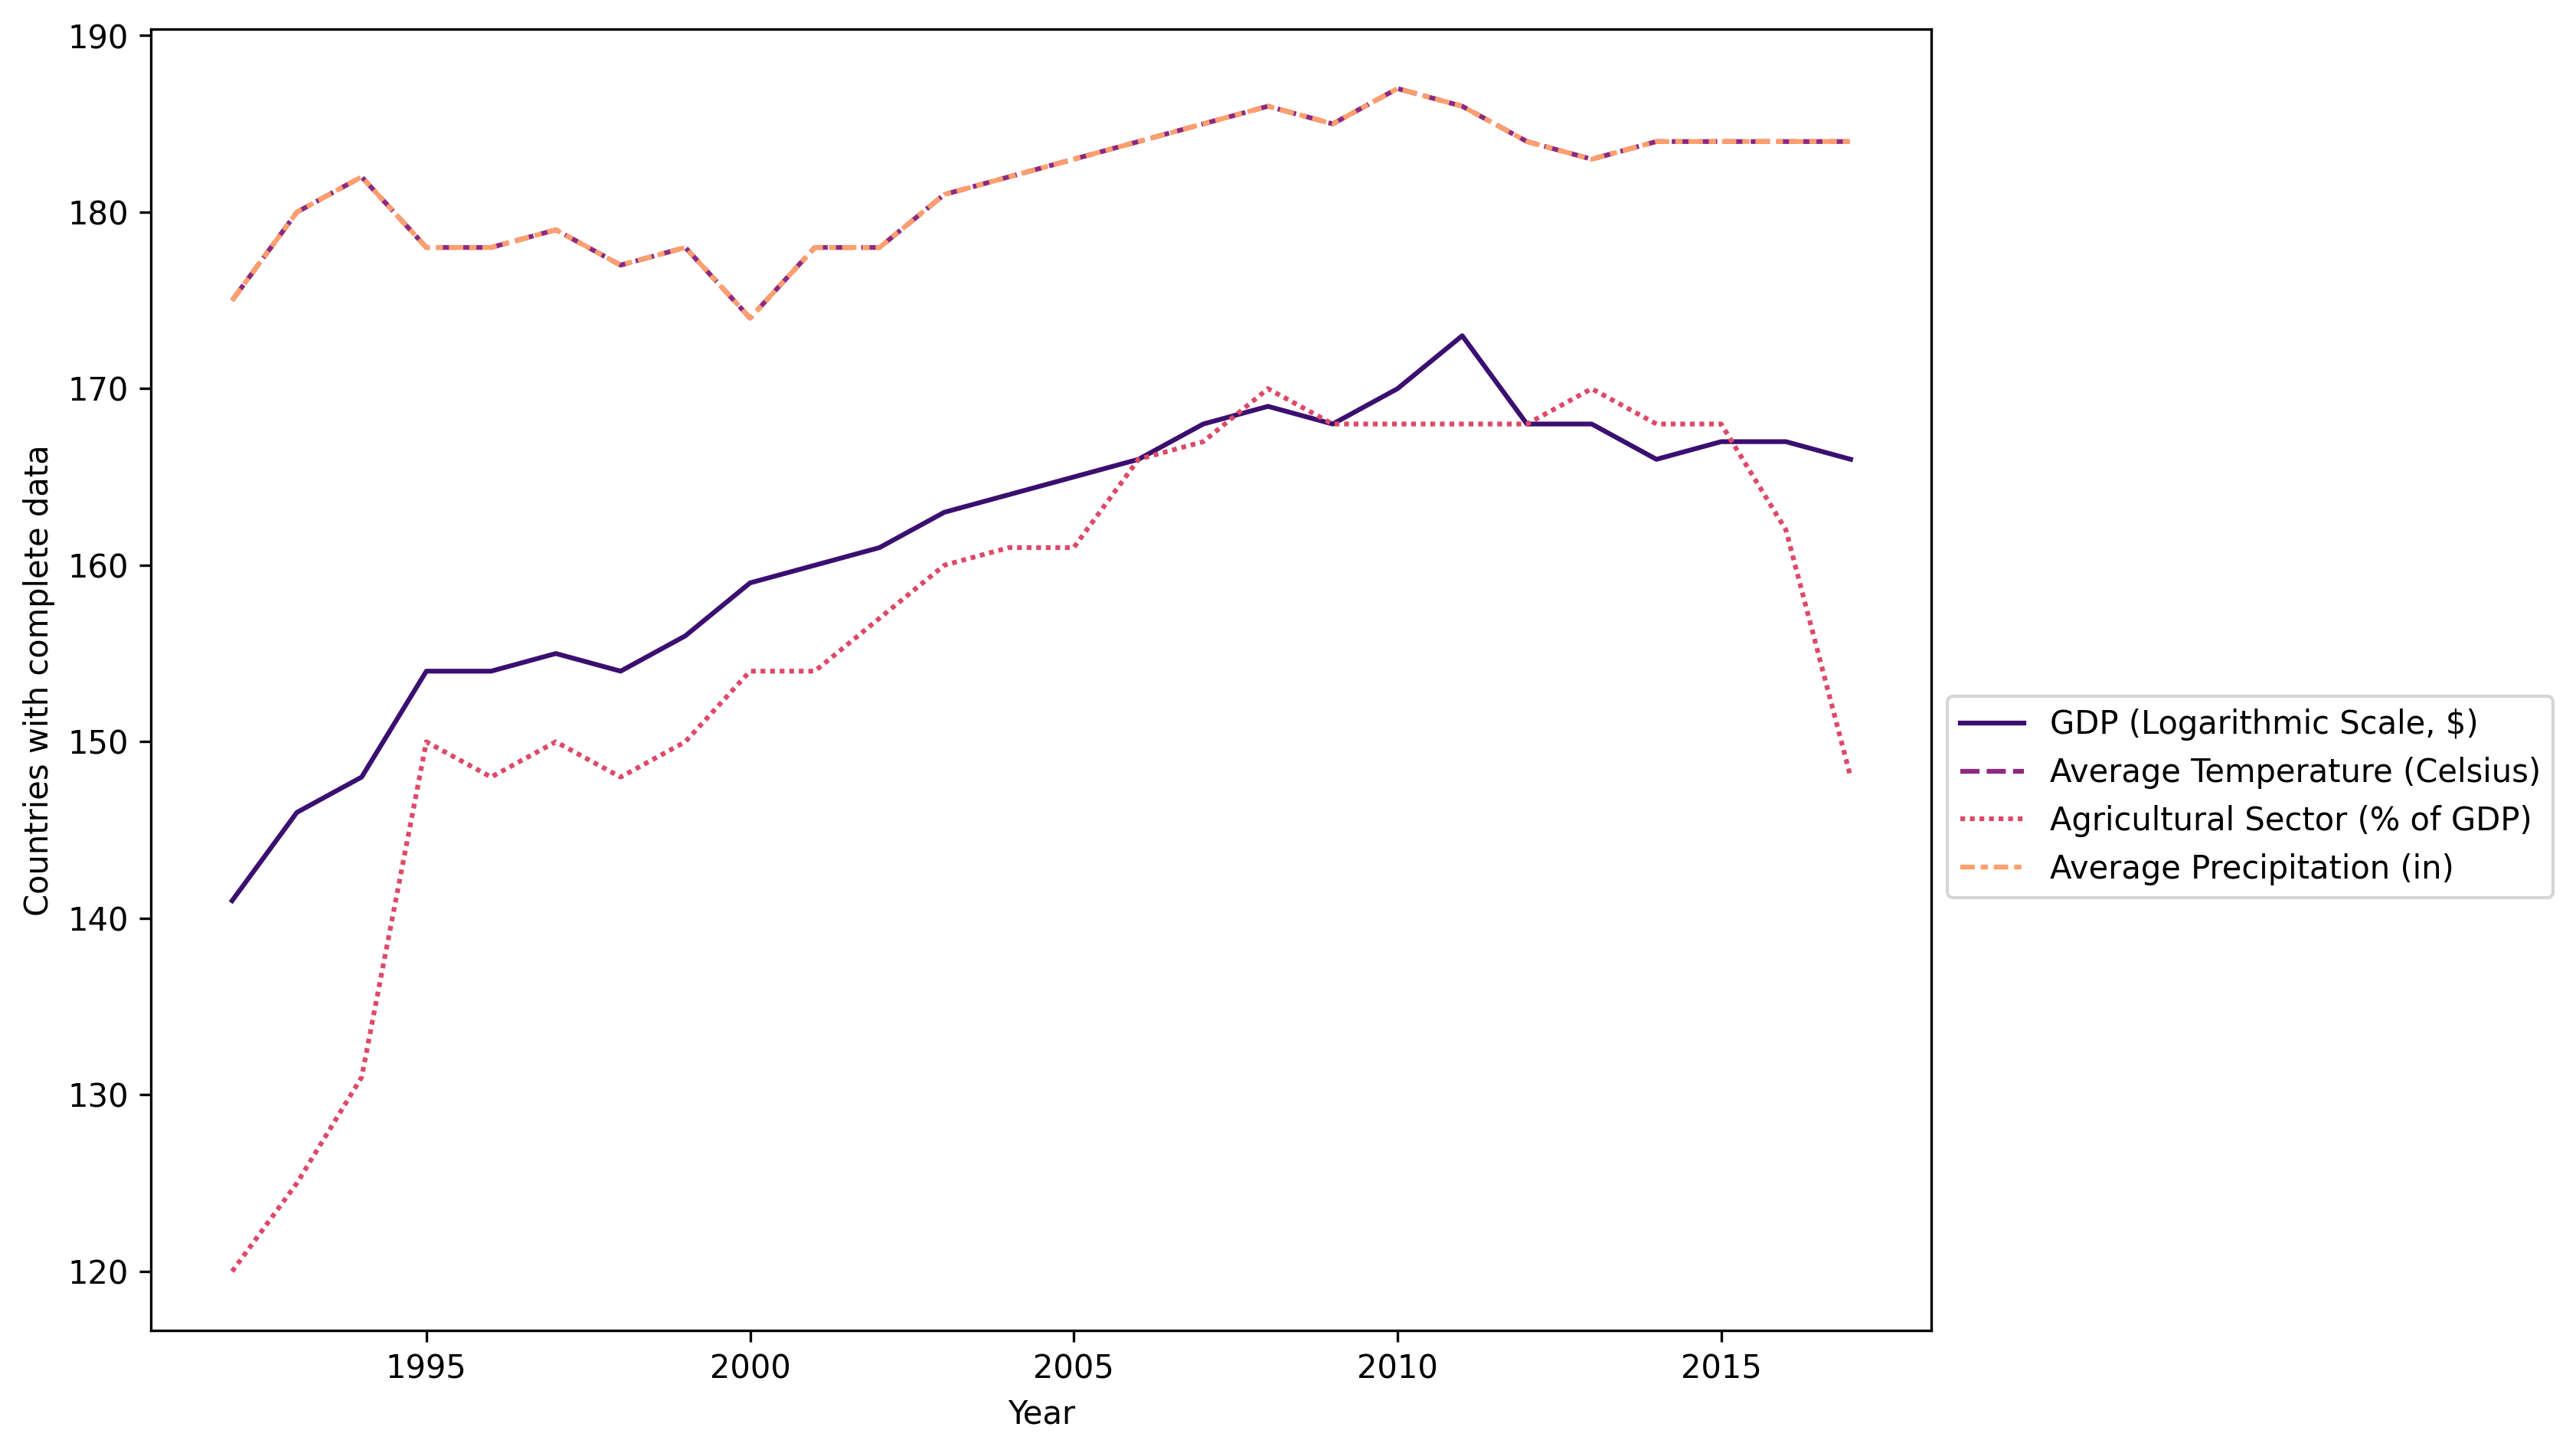

In [18]:
# # # Data Availability
plt.figure(figsize=(10,7.5))
plt.xlabel(xlabel='Year')
plt.ylabel(ylabel='Countries with complete data')
weather_GDP['Average Precipitation (in)']=weather_GDP['avg_precip']
sns.lineplot(data=weather_GDP[['GDP (Logarithmic Scale, $)','Average Temperature (Celsius)','Agricultural Sector (% of GDP)','Average Precipitation (in)','year']].groupby(['year']).count(),palette='magma')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.savefig("data_availability",pad_inches=0.5)
# weather_GDP.groupby(['year']).count().head()